In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import sys
import os
sys.path.append(os.path.abspath("../"))

from scripts.evaluate import evaluate_forecasts
from scripts.visualization import *

import warnings
from sklearn.exceptions import UndefinedMetricWarning

In [13]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [14]:
df_brl = pd.read_parquet('../data/all_comm/all_commodities_brl.parquet')

In [15]:
def extract_series(df):
    """
    Extrai informações relevantes de uma série temporal presente em um DataFrame agrupado por 'unique_id'.

    Para cada série identificada por 'unique_id', retorna:
    - a série completa,
    - os valores da variável alvo 'y',
    - os últimos 6 valores de 'y' (lags atuais).

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo colunas 'unique_id' e 'y'.

    Retorna:
    --------
    dict
        Dicionário em que a chave é o 'unique_id' da série, e o valor é um dicionário com:
        - 'series': DataFrame da série completa,
        - 'y_series': array com os valores da série,
        - 'v_curr_lags': últimos 6 valores (lags) da série.
    """
    series_data = {}

    for uid in df['unique_id'].unique():
        series = df[df['unique_id'] == uid]
        y_series = series['y'].values
        last_6_lags = y_series[-6:]

        series_data[uid] = {
            'series': series,
            'y_series': y_series,
            'v_curr_lags': last_6_lags
        }

    return series_data

# series_data_brl['SOJA']['series']: DataFrame da série de soja brl
# series_data_brl['SOJA']['y_series']: array dos valores y da soja brl
# series_data_brl['SOJA']['v_curr_lags']: últimos 6 valores de y da soja brl

# series_data_usd['SOJA']['series']: DataFrame da série de soja usd
# series_data_usd['SOJA']['y_series']: array dos valores y da soja usd
# series_data_usd['SOJA']['v_curr_lags']: últimos 6 valores de y da soja usd

In [16]:
def extract_lag_windows(series, window_size=6):
    """
    Extrai as janelas (lags) de uma série temporal para preparação dos dados de entrada
    e saída dos modelos.

    Para cada ponto no tempo, a função cria uma janela contendo os `window_size` valores anteriores,
    e associa essa janela ao valor seguinte da série como alvo (target).

    Parâmetros:
    -----------
    series : array-like
        Série temporal univa    riada (lista ou array do NumPy).
    
    window_size : int, opcional (default=6)
        Quantidade de valores anteriores (lags) que serão usados para formar as janelas.

    Retorna:
    --------
    tuple of np.ndarray
        - windows: array 2D de shape (n amostras, window_size), contendo as janelas de entrada.
        - targets: array 1D de shape (n amostras,), contendo os valores futuros correspondentes.
    """
    windows = []
    targets = []
    for i in range(window_size, len(series)-1):
        windows.append(series[i-window_size:i])
        targets.append(series[i])
    return np.array(windows), np.array(targets)

In [17]:
def evaluate_models(models, X, y):
    """
    Avalia um conjunto de modelos de regressão utilizando o erro quadrático médio (MSE)
    em um conjunto de dados fornecido.

    Cada modelo é treinado com os dados (X, y) e avaliado com previsões sobre o mesmo X.

    Parâmetros:
    -----------
    models : list
        Lista de modelos de regressão que implementam os métodos `.fit()` e `.predict()`.

    X : np.ndarray
        Matriz de entrada (janelas de lags).

    y : np.ndarray
        Vetor de saída (valores futuros correspondentes às janelas).

    Retorna:
    --------
    np.ndarray
        Vetor com os erros (MSE) de cada modelo na ordem em que foram fornecidos.
    """
    scores = []
    for model in models:
        model.fit(X, y)
        y_pred = model.predict(X)
        score = mean_squared_error(y, y_pred)
        scores.append(score)
    return np.array(scores)

In [18]:
def plot_forecast(y_series, forecast, horizon, series_id):
    """
    Gera o gráfico da série real e da previsão recursiva.

    Parâmetros:
    -----------
    y_series : array-like
        Série temporal completa com valores reais.

    forecast : array-like
        Lista de valores previstos para os próximos `horizon` passos.

    horizon : int
        Número de passos futuros previstos.

    series_id : str
        Identificador da série (usado no título do gráfico).

    Retorna:
    --------
    None
        Exibe o gráfico com a série real e os valores previstos.
    """
    x_real = np.arange(len(y_series))
    x_forecast = np.arange(len(y_series) - horizon, len(y_series))

    plt.figure(figsize=(14, 5))
    plt.plot(x_real, y_series, label='Série real', color='blue')
    plt.plot(x_forecast, forecast, label='Previsão', color='orange')
    plt.title(f'{series_id} - Previsão Recursiva de {horizon} passos com DCS-LA')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [19]:
# poool de preditores

models = [
    LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        verbose=-1
    ),
    XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        verbosity=0
    ),
    KNeighborsRegressor(
        n_neighbors=5,
        weights='distance'
    ),
    MLPRegressor(
        hidden_layer_sizes=(50, 25),
        max_iter=1000,
        early_stopping=False,
        random_state=42
    ),
    RandomForestRegressor(
        n_estimators=100,
        max_depth=3,
        random_state=42
    )
]

In [20]:
series_data_brl = extract_series(df_brl)
# series_data_usd = extract_series(df_usd)

# Params
horizon_size = 12  # número de passos futuros a prever
window_size = 6 # tamanho da janela

## BRL

### Similaridade por Cosseno


==> Série: ACUCAR_SANTOS
Valores reais:     [139.45, 137.53, 136.99, 138.63, 139.31, 136.6, 135.68, 135.2, 137.06, 133.83, 131.98, 130.79]
Valores previstos: [139.94, 140.43, 141.63, 147.09, 143.61, 144.58, 146.79, 146.85, 146.62, 146.67, 145.8, 146.65]
MSE da previsão recursiva (12 passos): 95.1713


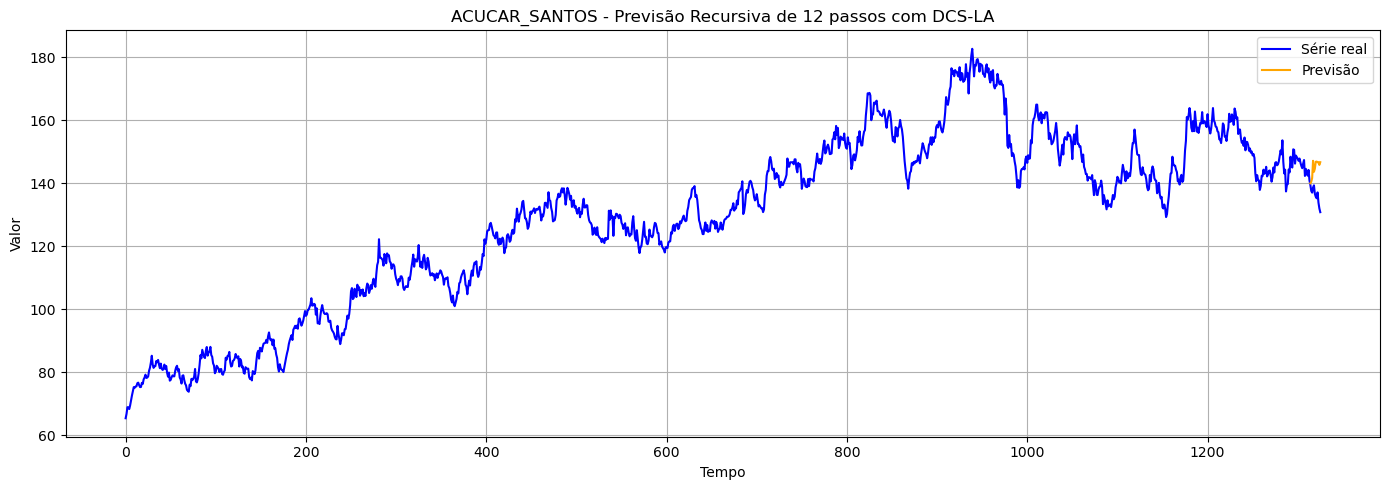


==> Série: ACUCAR_SP
Valores reais:     [141.59, 142.35, 142.68, 142.47, 144.31, 144.87, 144.64, 143.62, 143.81, 143.04, 142.84, 143.92]
Valores previstos: [64.07, 49.86, 48.69, 46.21, 47.28, 46.6, 44.8, 41.09, 42.47, 44.25, 42.11, 41.46]
MSE da previsão recursiva (12 passos): 9407.2767


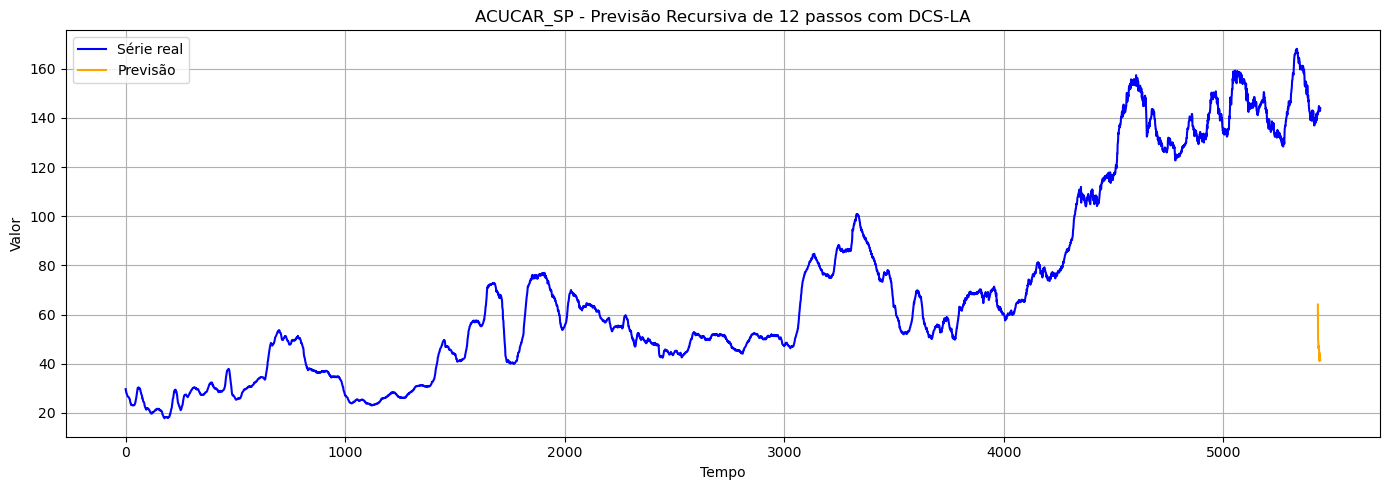


==> Série: ALGODAO
Valores reais:     [424.3, 427.85, 429.99, 426.47, 428.88, 432.54, 430.54, 433.75, 434.22, 433.14, 438.1, 438.71]
Valores previstos: [363.4, 289.98, 288.42, 283.25, 272.36, 270.87, 256.91, 210.56, 249.39, 246.82, 213.11, 225.14]
MSE da previsão recursiva (12 passos): 29914.6922


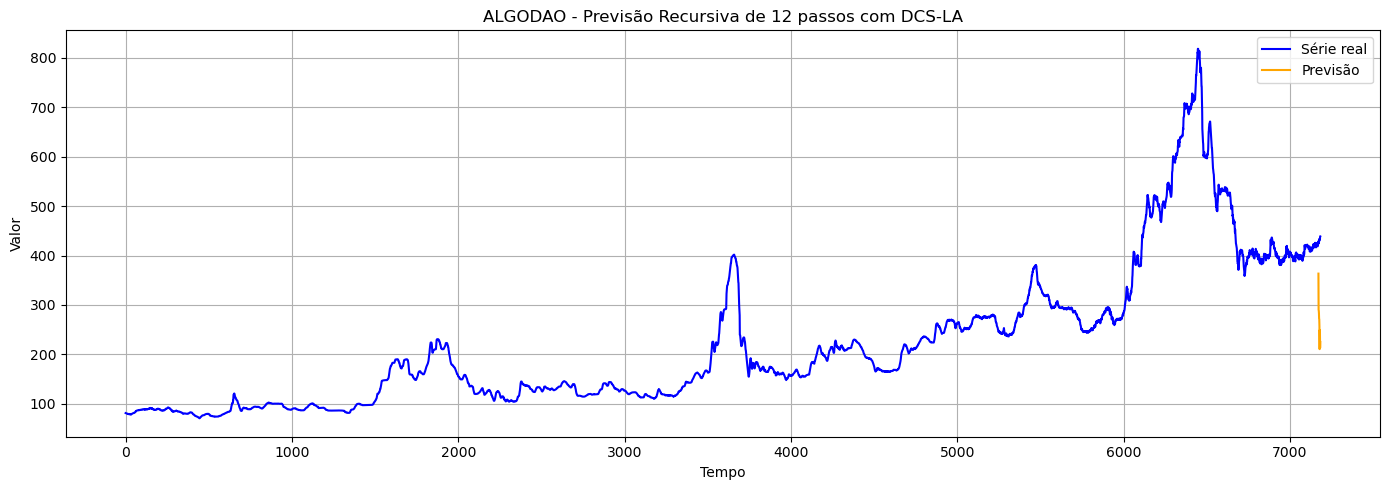


==> Série: ARROZ
Valores reais:     [76.23, 76.29, 76.3, 76.17, 76.04, 76.3, 76.52, 76.03, 76.06, 76.04, 76.09, 75.92]
Valores previstos: [54.62, 74.45, 64.79, 72.39, 73.1, 73.24, 91.99, 89.4, 92.89, 91.21, 93.33, 97.37]
MSE da previsão recursiva (12 passos): 193.6722


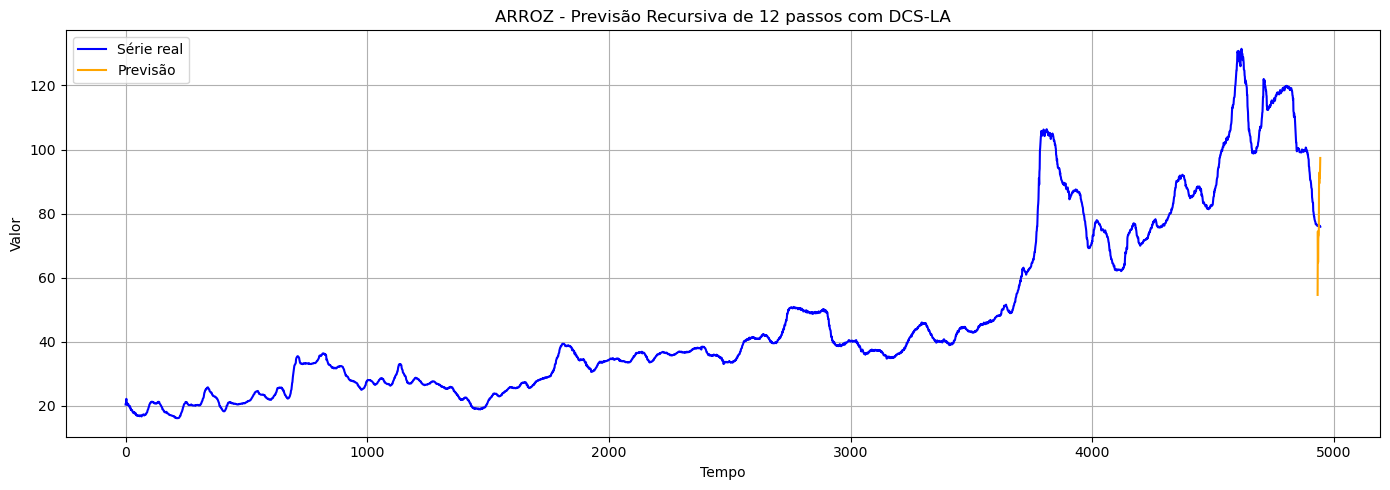


==> Série: CAFE_ARABICA
Valores reais:     [2423.8, 2480.6, 2496.83, 2530.29, 2520.65, 2521.98, 2563.95, 2593.24, 2611.02, 2658.07, 2665.07, 2616.02]
Valores previstos: [604.18, 545.14, 281.92, 607.19, 522.8, 281.77, 328.88, 298.2, 280.47, 305.11, 262.03, 241.44]
MSE da previsão recursiva (12 passos): 4776245.2624


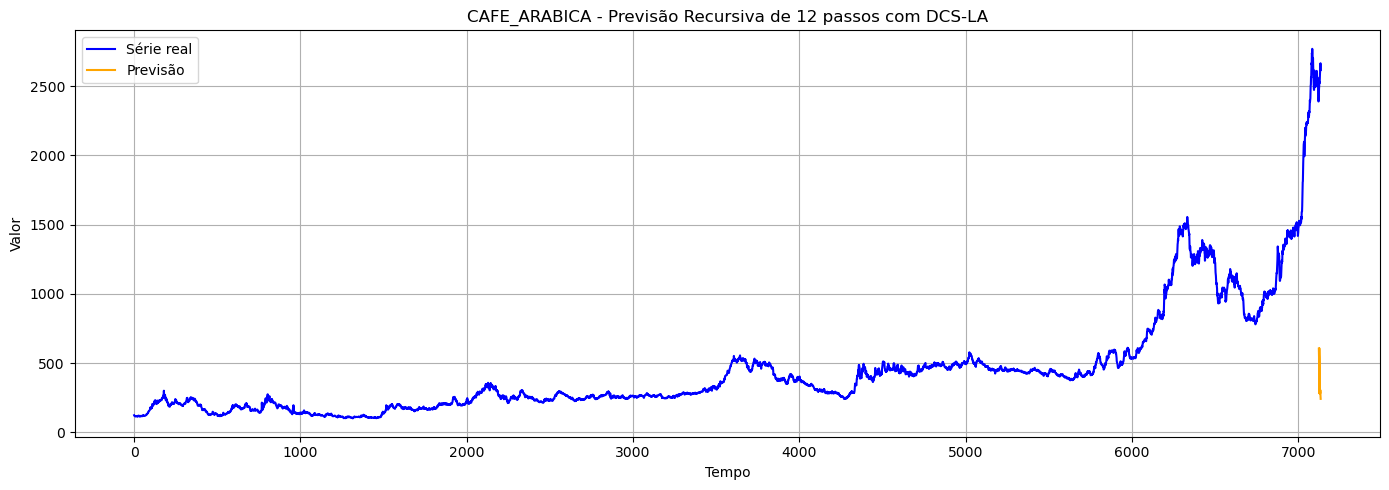


==> Série: CAFE_ROBUSTA
Valores reais:     [1608.88, 1635.37, 1693.93, 1711.84, 1712.52, 1671.17, 1692.53, 1698.85, 1716.34, 1714.84, 1714.79, 1702.68]
Valores previstos: [1502.95, 399.43, 1056.42, 1033.49, 1123.14, 1073.41, 1004.41, 590.82, 906.07, 919.98, 887.07, 865.32]
MSE da previsão recursiva (12 passos): 623826.2764


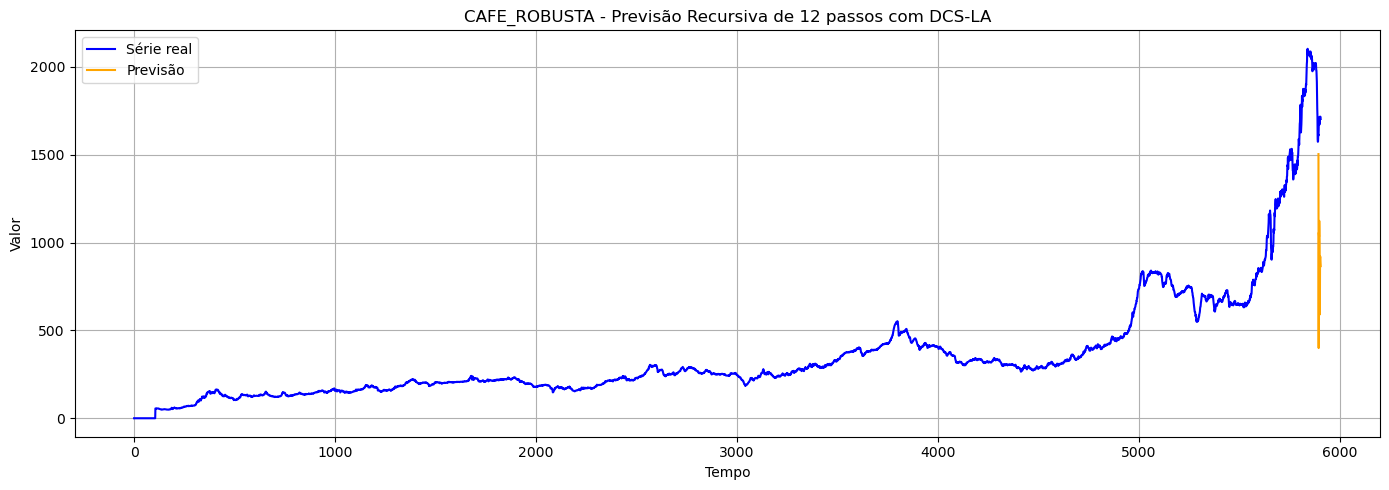


==> Série: MILHO
Valores reais:     [84.98, 85.3, 84.71, 83.78, 83.49, 82.57, 81.97, 81.6, 80.54, 80.49, 80.37, 80.13]
Valores previstos: [84.22, 52.07, 59.56, 48.05, 51.49, 47.19, 44.5, 44.66, 44.11, 45.83, 44.14, 42.86]
MSE da previsão recursiva (12 passos): 1107.3982


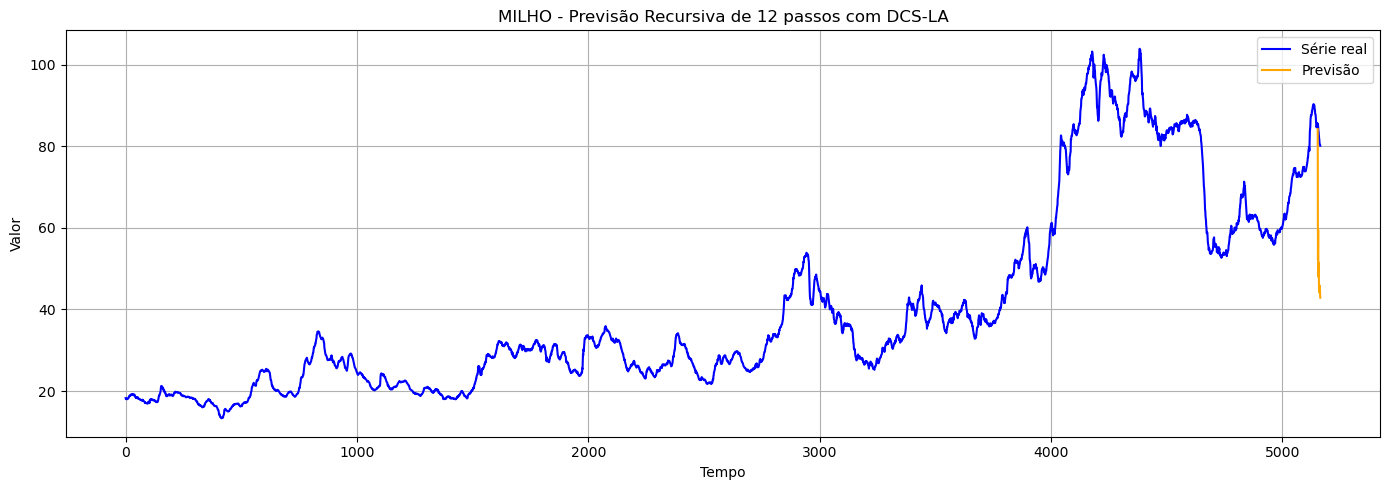


==> Série: SOJA_PARANA
Valores reais:     [132.33, 132.56, 131.48, 132.15, 131.91, 130.19, 129.92, 129.06, 130.14, 129.87, 129.22, 127.79]
Valores previstos: [92.42, 79.07, 74.11, 68.14, 54.33, 56.84, 46.04, 43.22, 44.72, 44.37, 44.73, 42.88]
MSE da previsão recursiva (12 passos): 5550.1587


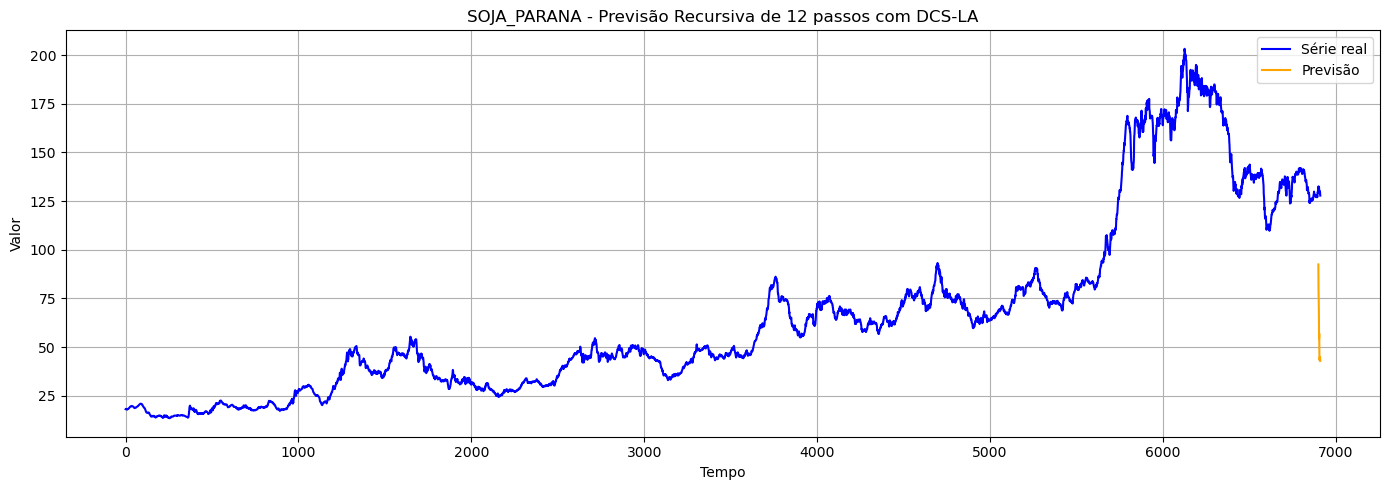


==> Série: SOJA_PARANAGUA
Valores reais:     [137.89, 137.18, 135.3, 136.7, 135.61, 134.31, 135.03, 135.13, 135.04, 134.42, 132.59, 132.14]
Valores previstos: [134.36, 129.42, 94.39, 71.59, 71.49, 72.88, 72.92, 71.77, 70.06, 57.15, 65.01, 64.88]
MSE da previsão recursiva (12 passos): 3418.8563


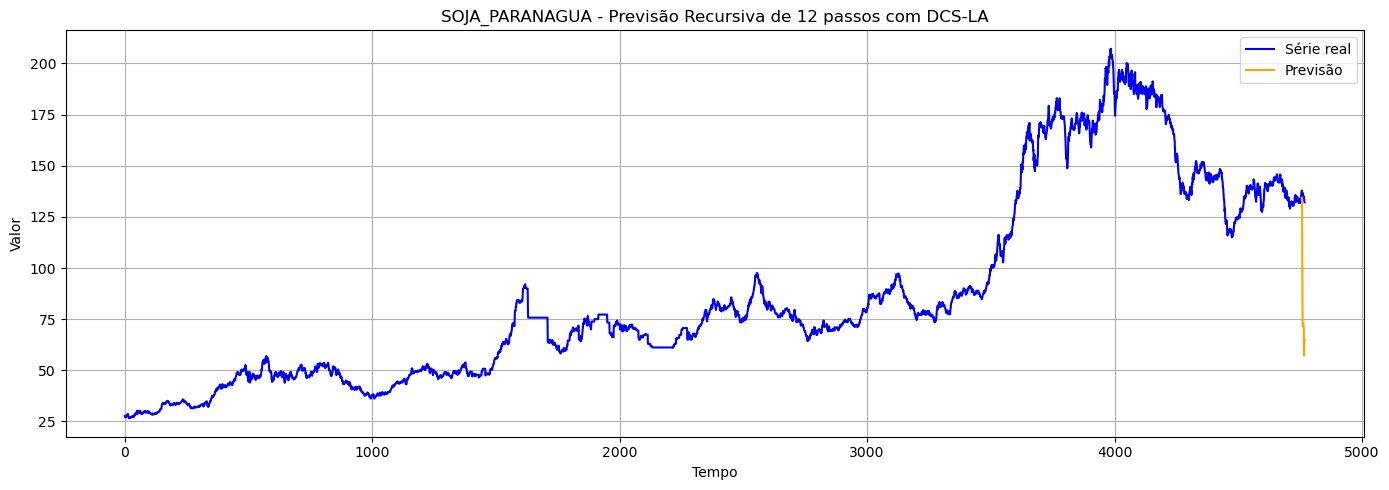


==> Série: TRIGO_PARANA
Valores reais:     [1573.46, 1572.25, 1579.17, 1579.48, 1579.5, 1574.81, 1576.34, 1579.77, 1578.32, 1573.47, 1575.95, 1571.96]
Valores previstos: [1746.68, 1100.95, 933.82, 1103.95, 1072.83, 985.32, 823.95, 878.72, 880.29, 893.26, 841.03, 870.09]
MSE da previsão recursiva (12 passos): 378264.6878


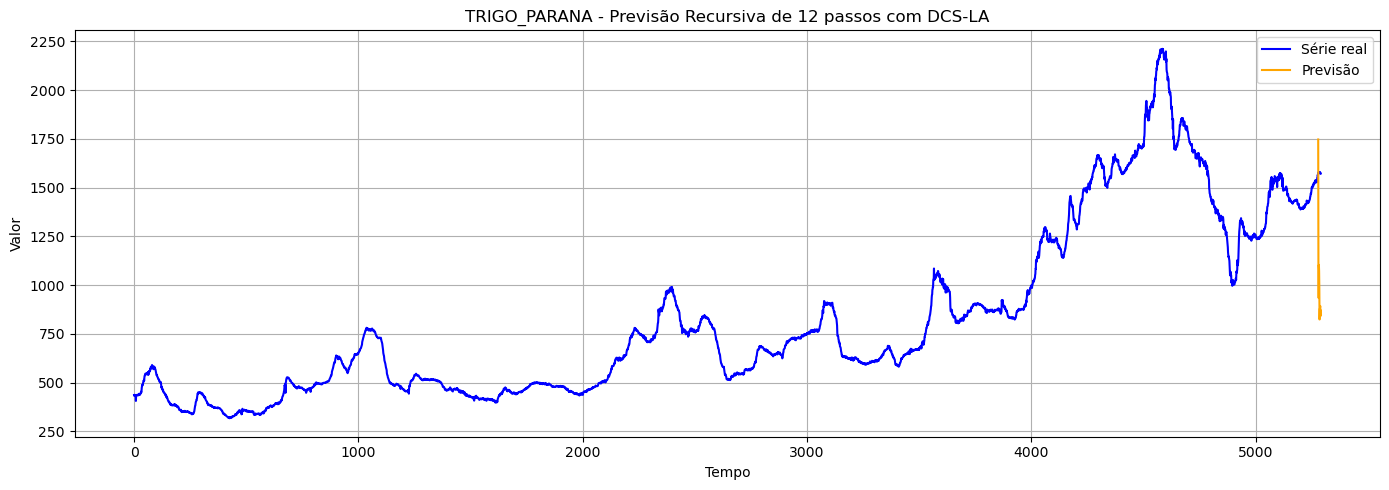


==> Série: TRIGO_RS
Valores reais:     [1474.91, 1474.97, 1482.14, 1478.15, 1479.7, 1469.5, 1469.64, 1476.85, 1476.85, 1483.36, 1473.82, 1471.23]
Valores previstos: [1376.87, 1016.79, 741.59, 741.67, 752.8, 754.16, 734.78, 743.6, 739.94, 737.07, 648.71, 694.66]
MSE da previsão recursiva (12 passos): 484331.3977


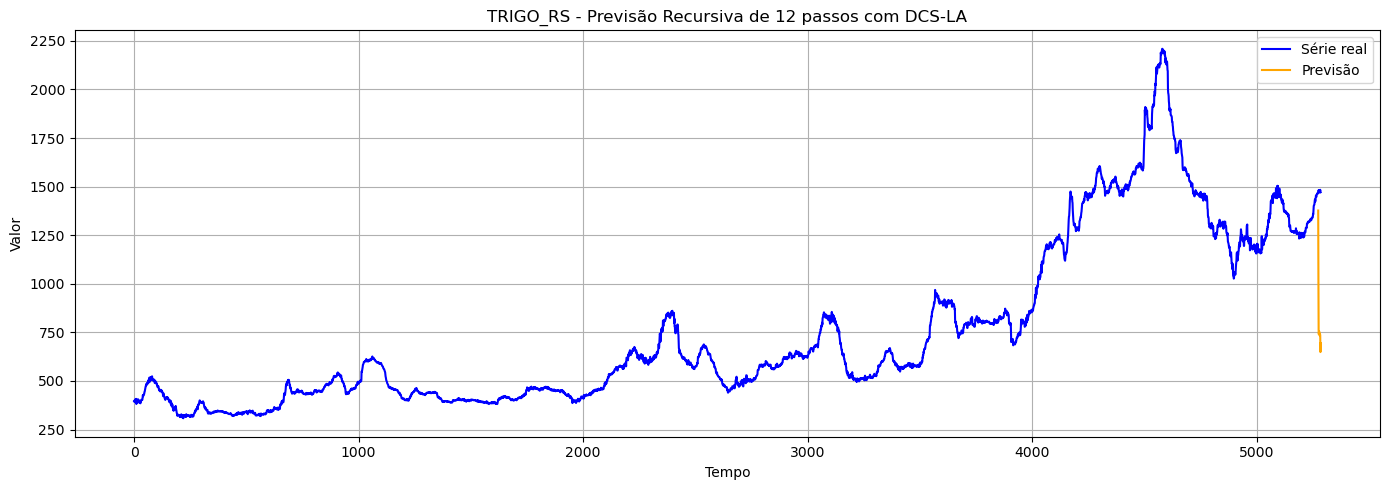

In [21]:
for id in df_brl['unique_id'].unique():
    print(f'\n==> Série: {id}')

    y_series = series_data_brl[id]['y_series']     # array com os valores alvo da série
    y_real_future = y_series[-horizon_size:]       # últimos 12 pontos reais para avaliação
    y_train = y_series[:-horizon_size]             # parte separada para gerar as janelas e treinar os modelos

    curr_lags = y_train[-window_size:]             # criação da primeira região de dependência (últimos *window_size* pontos do treino)
    forecast = []                                  # lista para add os *horizon_size* valores previstos

    for step in range(horizon_size):
        # extrai janelas e targets do histórico até agora (incluindo previsões anteriores)
        windows, targets = extract_lag_windows(y_train, window_size=window_size)

        # calcula similaridade da região atual com todas janelas anteriores
        sims = cosine_similarity([curr_lags], windows)[0]
        top_k_idx = sims.argsort()[-10:]  # top 10 janelas mais similares

        competence_X = windows[top_k_idx]
        competence_y = targets[top_k_idx]

        # seleciona o melhor modelo com base no erro (MSE)
        errors = evaluate_models(models, competence_X, competence_y)
        best_model = models[np.argmin(errors)]

        # realiza a previsão para o próximo ponto
        y_next = best_model.predict([curr_lags])[0]
        forecast.append(y_next)

        # atualiza os lags e o histórico com o valor previsto
        curr_lags = np.append(curr_lags[1:], y_next)
        y_train = np.append(y_train, y_next)

    # avaliação dos valores reais e previstos + mse
    print("Valores reais:    ", y_real_future.round(2).tolist())
    print("Valores previstos:", np.round(forecast, 2).tolist())
    mse = mean_squared_error(y_real_future, forecast)
    print(f"MSE da previsão recursiva ({horizon_size} passos): {mse:.4f}")

    plot_forecast(y_series, forecast, horizon_size, id)

    # y_train n pegar a própria janela
    # n passar minha previsão pra prox janela
    # fazer a comparação com os modelos sozinhos
    # conceito de oracle
    # overall local accuracy

### Similaridade por Distância Euclidiana


==> Série: ACUCAR_SANTOS
Valores reais:     [139.45, 137.53, 136.99, 138.63, 139.31, 136.6, 135.68, 135.2, 137.06, 133.83, 131.98, 130.79]
Valores previstos: [141.7, 142.65, 142.77, 142.21, 142.43, 142.34, 141.89, 141.95, 142.06, 141.47, 141.93, 141.94]
MSE da previsão recursiva (12 passos): 42.5670


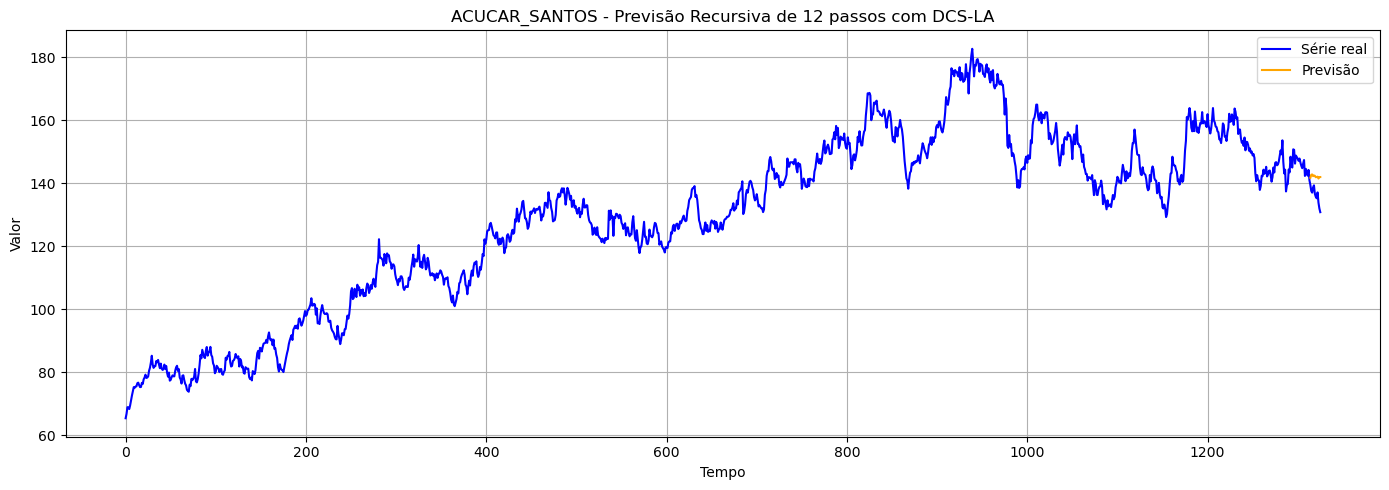


==> Série: ACUCAR_SP
Valores reais:     [141.59, 142.35, 142.68, 142.47, 144.31, 144.87, 144.64, 143.62, 143.81, 143.04, 142.84, 143.92]
Valores previstos: [142.12, 142.15, 142.65, 143.18, 144.59, 145.23, 145.51, 145.43, 144.52, 144.65, 145.24, 145.33]
MSE da previsão recursiva (12 passos): 1.3243


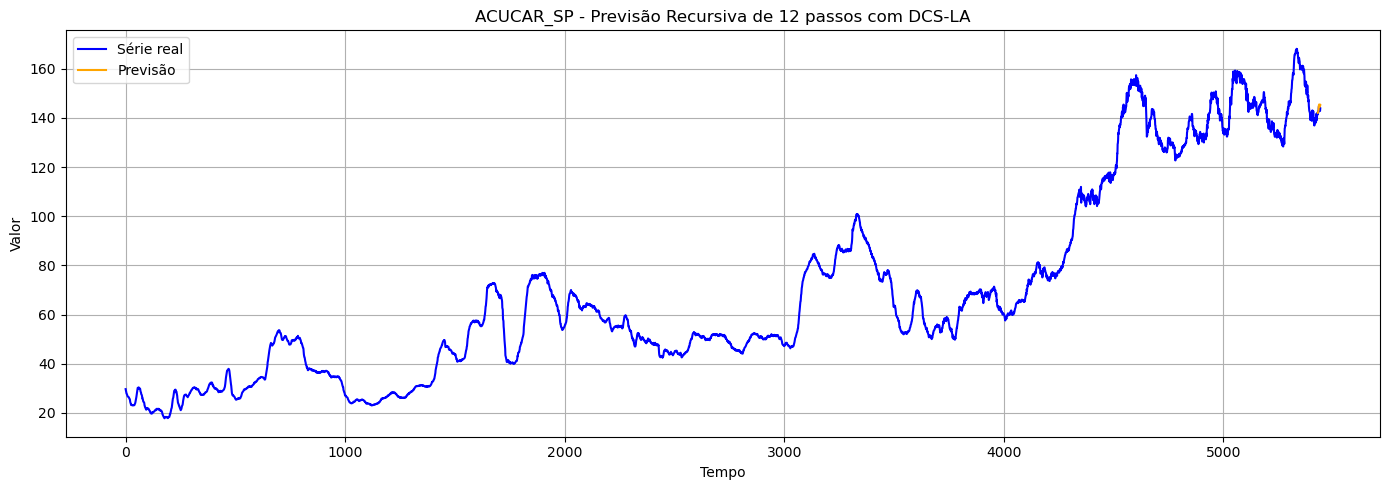


==> Série: ALGODAO
Valores reais:     [424.3, 427.85, 429.99, 426.47, 428.88, 432.54, 430.54, 433.75, 434.22, 433.14, 438.1, 438.71]
Valores previstos: [421.31, 421.88, 420.06, 420.28, 419.96, 421.29, 420.64, 420.15, 420.12, 420.13, 420.27, 420.2]
MSE da previsão recursiva (12 passos): 141.6097


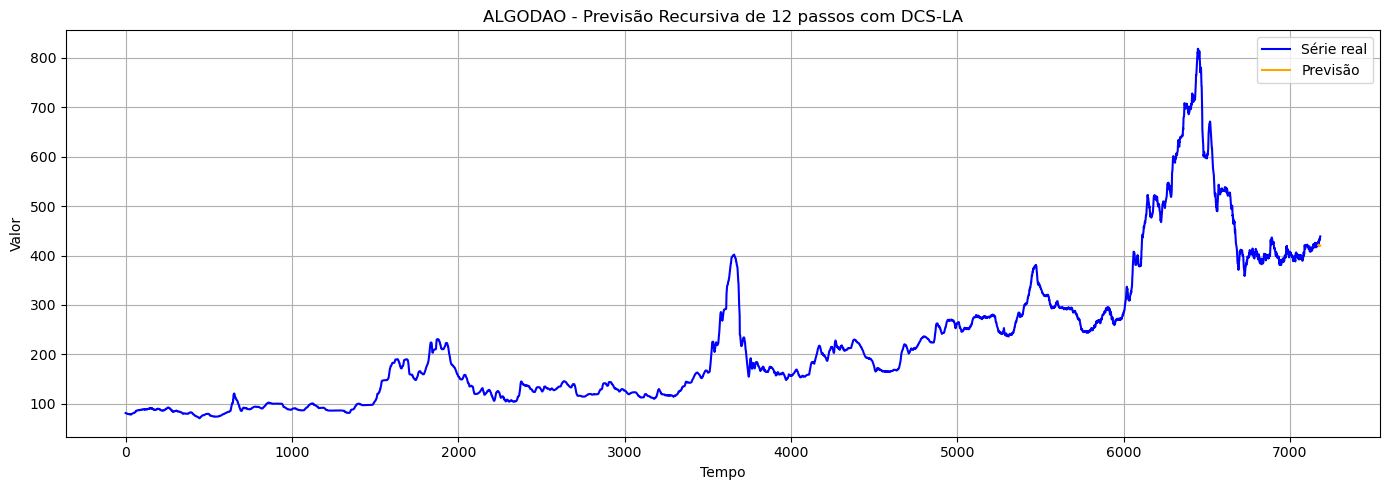


==> Série: ARROZ
Valores reais:     [76.23, 76.29, 76.3, 76.17, 76.04, 76.3, 76.52, 76.03, 76.06, 76.04, 76.09, 75.92]
Valores previstos: [76.21, 75.97, 75.86, 75.75, 75.7, 75.81, 75.81, 75.88, 76.03, 75.98, 75.99, 76.01]
MSE da previsão recursiva (12 passos): 0.1145


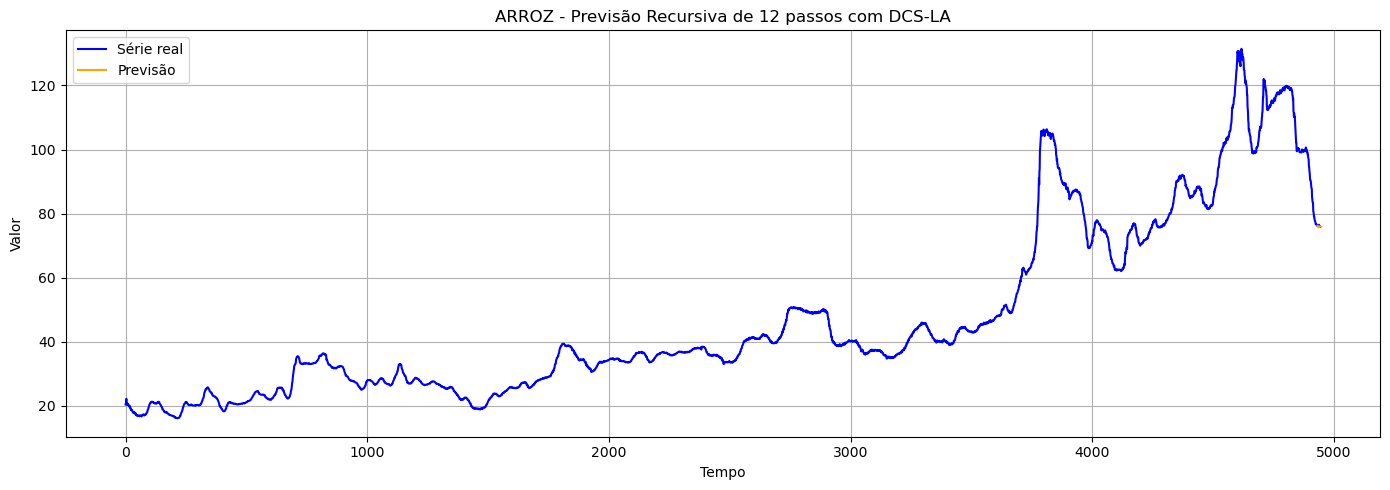


==> Série: CAFE_ARABICA
Valores reais:     [2423.8, 2480.6, 2496.83, 2530.29, 2520.65, 2521.98, 2563.95, 2593.24, 2611.02, 2658.07, 2665.07, 2616.02]
Valores previstos: [2511.85, 2542.32, 2543.51, 2556.7, 2585.81, 2617.25, 2603.65, 2580.43, 2545.64, 2535.67, 2540.06, 2549.44]
MSE da previsão recursiva (12 passos): 5734.5620


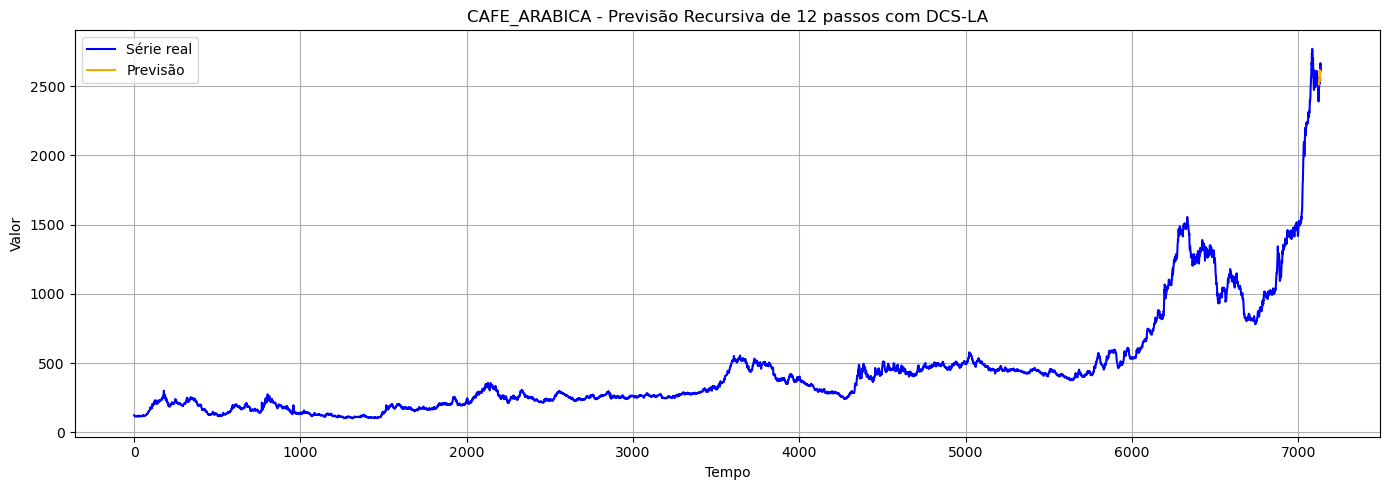


==> Série: CAFE_ROBUSTA
Valores reais:     [1608.88, 1635.37, 1693.93, 1711.84, 1712.52, 1671.17, 1692.53, 1698.85, 1716.34, 1714.84, 1714.79, 1702.68]
Valores previstos: [1713.13, 1746.47, 1761.02, 1766.42, 1760.41, 1729.37, 1742.94, 1731.86, 1752.48, 1759.55, 1751.07, 1744.87]
MSE da previsão recursiva (12 passos): 3867.0051


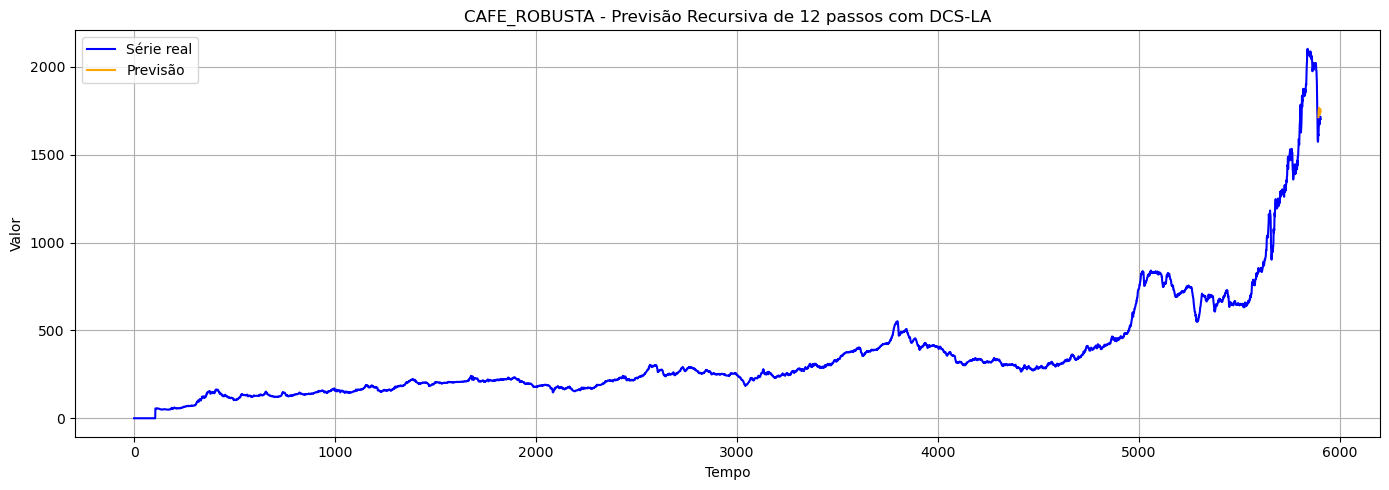


==> Série: MILHO
Valores reais:     [84.98, 85.3, 84.71, 83.78, 83.49, 82.57, 81.97, 81.6, 80.54, 80.49, 80.37, 80.13]
Valores previstos: [85.2, 85.35, 85.28, 84.87, 84.81, 85.21, 85.49, 85.37, 85.09, 85.06, 85.02, 85.16]
MSE da previsão recursiva (12 passos): 10.4511


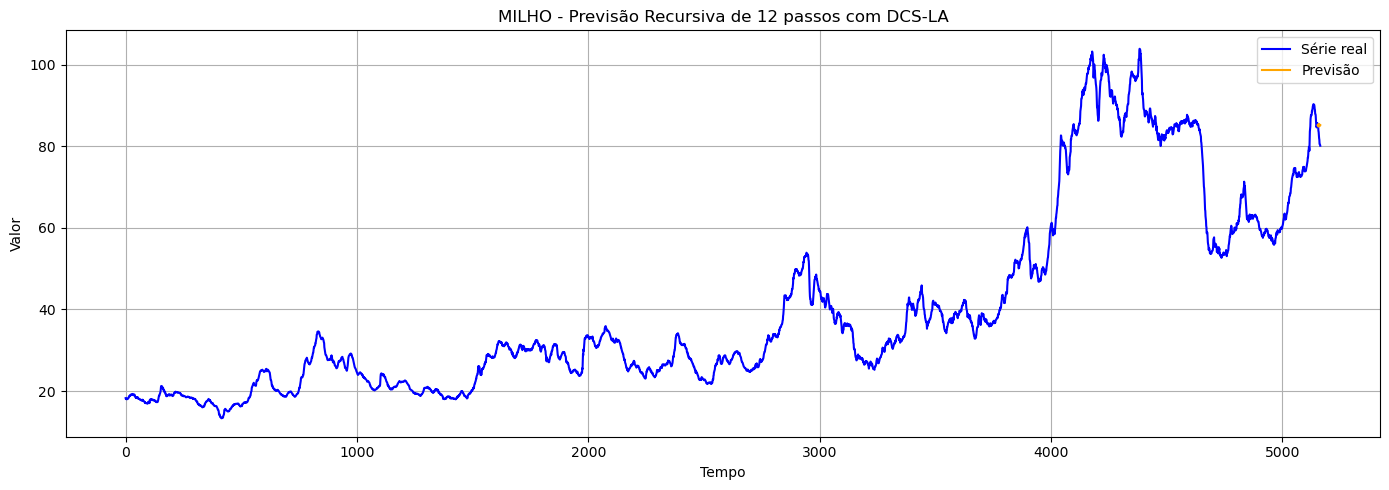


==> Série: SOJA_PARANA
Valores reais:     [132.33, 132.56, 131.48, 132.15, 131.91, 130.19, 129.92, 129.06, 130.14, 129.87, 129.22, 127.79]
Valores previstos: [129.62, 129.55, 128.92, 129.5, 129.51, 129.07, 129.74, 130.21, 130.68, 131.25, 132.27, 133.56]
MSE da previsão recursiva (12 passos): 6.9306


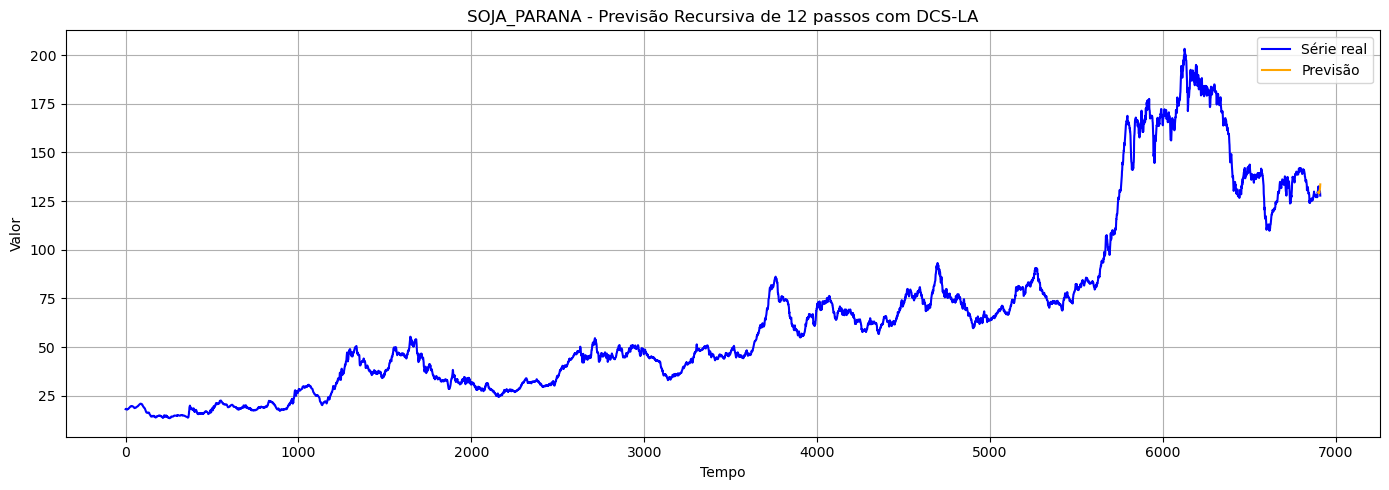


==> Série: SOJA_PARANAGUA
Valores reais:     [137.89, 137.18, 135.3, 136.7, 135.61, 134.31, 135.03, 135.13, 135.04, 134.42, 132.59, 132.14]
Valores previstos: [137.91, 138.65, 138.77, 138.32, 139.69, 138.63, 138.05, 137.29, 136.28, 135.24, 137.14, 137.55]
MSE da previsão recursiva (12 passos): 9.8509


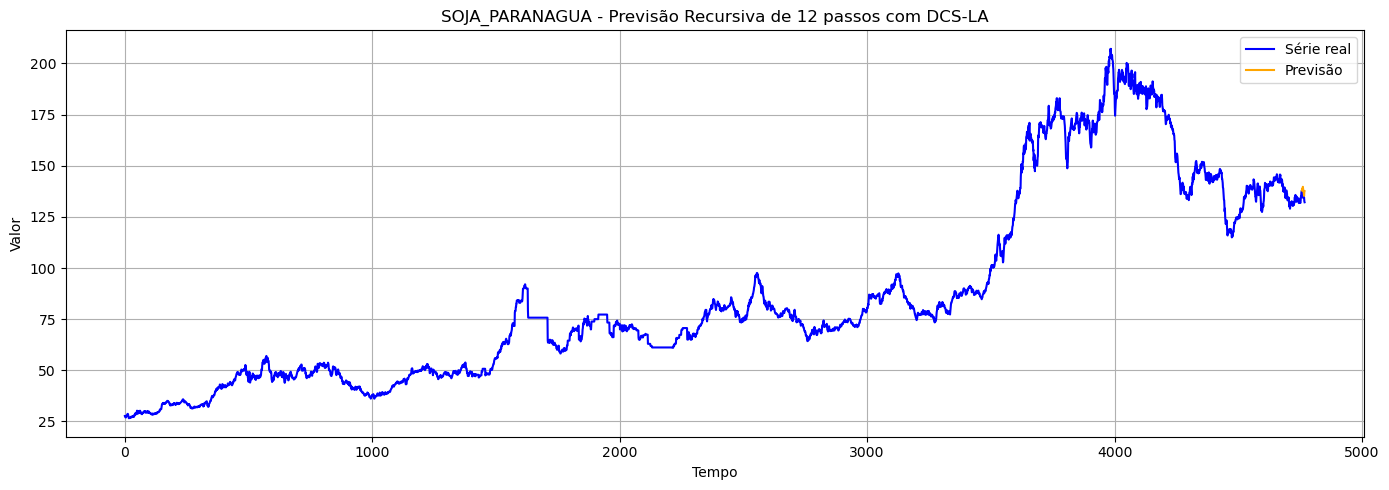


==> Série: TRIGO_PARANA
Valores reais:     [1573.46, 1572.25, 1579.17, 1579.48, 1579.5, 1574.81, 1576.34, 1579.77, 1578.32, 1573.47, 1575.95, 1571.96]
Valores previstos: [1556.78, 1559.55, 1562.8, 1567.98, 1561.51, 1560.12, 1559.08, 1560.06, 1559.64, 1556.35, 1561.22, 1560.6]
MSE da previsão recursiva (12 passos): 254.4606


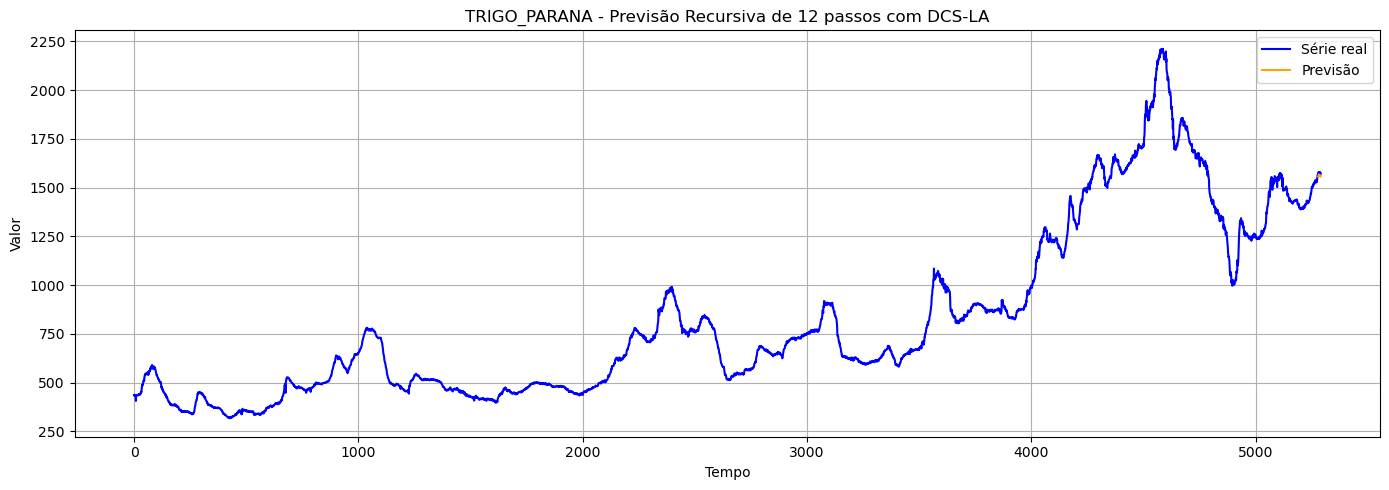


==> Série: TRIGO_RS
Valores reais:     [1474.91, 1474.97, 1482.14, 1478.15, 1479.7, 1469.5, 1469.64, 1476.85, 1476.85, 1483.36, 1473.82, 1471.23]
Valores previstos: [1457.59, 1454.75, 1460.57, 1458.91, 1457.84, 1455.08, 1454.09, 1456.32, 1455.0, 1454.12, 1454.47, 1455.97]
MSE da previsão recursiva (12 passos): 402.7514


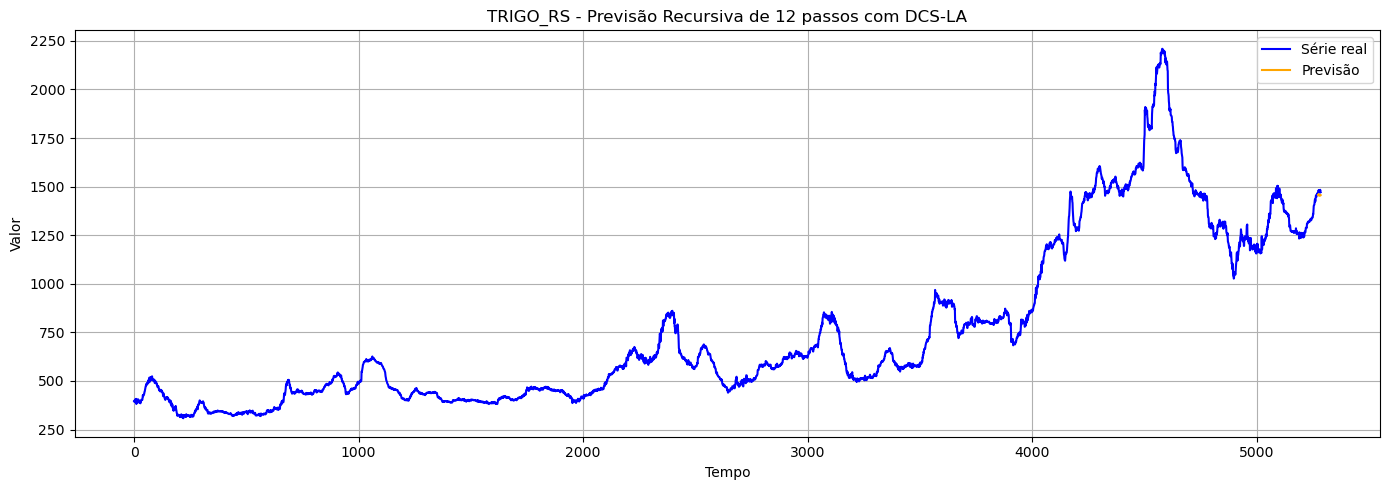

In [22]:
for id in df_brl['unique_id'].unique():
    print(f'\n==> Série: {id}')

    y_series = series_data_brl[id]['y_series']     # array com os valores alvo da série
    y_real_future = y_series[-horizon_size:]       # últimos 12 pontos reais para avaliação
    y_train = y_series[:-horizon_size]             # parte separada para gerar as janelas e treinar os modelos

    curr_lags = y_train[-window_size:]             # criação da primeira região de dependência (últimos *window_size* pontos do treino)
    forecast = []                                  # lista para add os *horizon_size* valores previstos

    for step in range(horizon_size):
        # extrai janelas e targets do histórico até agora (incluindo previsões anteriores)
        windows, targets = extract_lag_windows(y_train, window_size=window_size)

        # calcula similaridade da região atual com todas janelas anteriores
        dists = euclidean_distances([curr_lags], windows)[0]
        top_k_idx = dists.argsort()[:10]  # top 10 janelas mais próximas (menores distâncias)

        competence_X = windows[top_k_idx]
        competence_y = targets[top_k_idx]

        # seleciona o melhor modelo com base no erro (MSE)
        errors = evaluate_models(models, competence_X, competence_y)
        best_model = models[np.argmin(errors)]

        # realiza a previsão para o próximo ponto
        y_next = best_model.predict([curr_lags])[0]
        forecast.append(y_next)

        # atualiza os lags e o histórico com o valor previsto
        curr_lags = np.append(curr_lags[1:], y_next)
        y_train = np.append(y_train, y_next)

    # avaliação dos valores reais e previstos + mse
    print("Valores reais:    ", y_real_future.round(2).tolist())
    print("Valores previstos:", np.round(forecast, 2).tolist())
    mse = mean_squared_error(y_real_future, forecast)
    print(f"MSE da previsão recursiva ({horizon_size} passos): {mse:.4f}")

    plot_forecast(y_series, forecast, horizon_size, id)

## USD

### Similaridade por Cosseno


==> Série: ACUCAR
Valores reais:     [28.84, 28.72, 27.06, 25.17, 24.0, 23.55, 25.48, 27.15, 28.68, 26.51, 25.82, 25.23]
Valores previstos: [21.42, 23.44, 20.79, 17.16, 17.61, 17.54, 16.55, 17.17, 15.74, 14.52, 15.65, 16.41]
MSE da previsão recursiva (12 passos): 77.9299


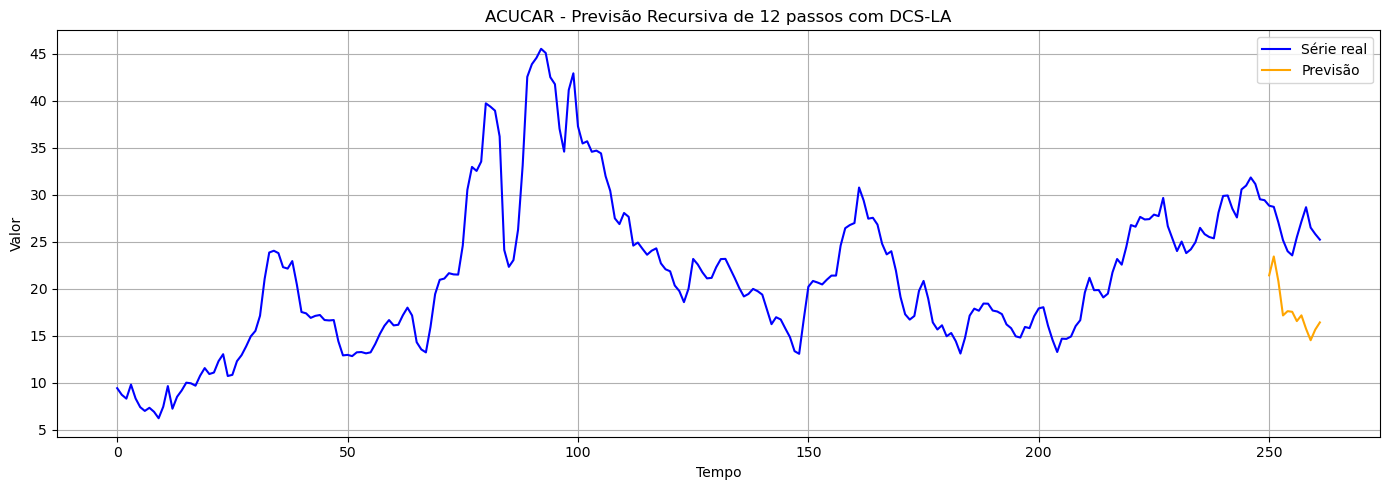


==> Série: ALGODAO
Valores reais:     [84.43, 77.64, 74.9, 72.75, 73.4, 71.95, 71.49, 70.42, 68.08, 67.89, 68.92, 71.48]
Valores previstos: [82.37, 83.25, 83.03, 81.97, 82.0, 81.02, 81.75, 81.36, 81.11, 81.84, 81.6, 81.62]
MSE da previsão recursiva (12 passos): 99.6408


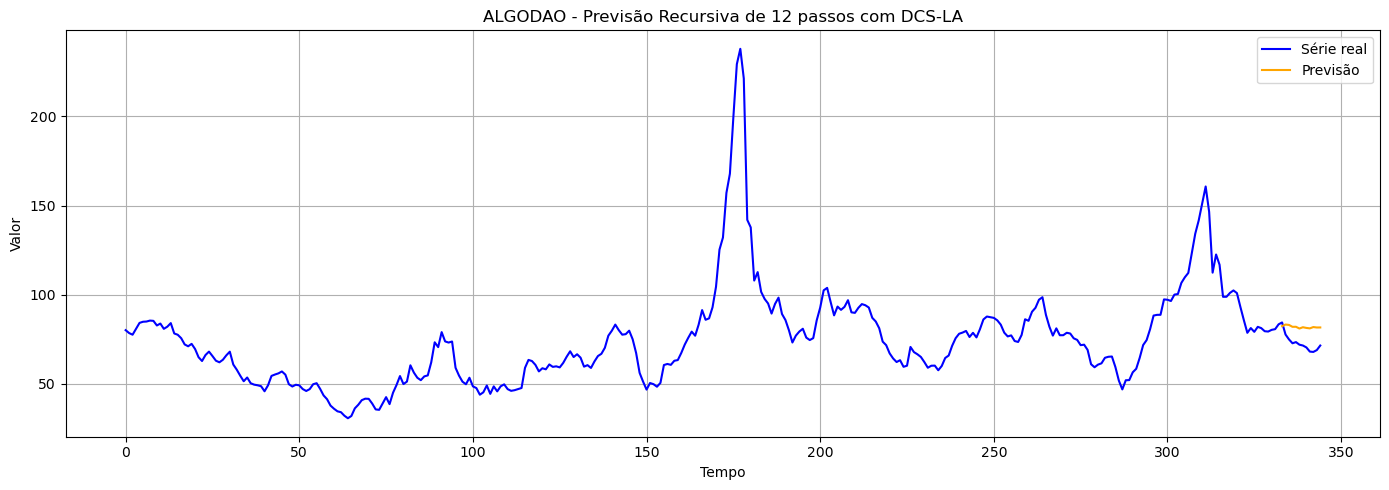


==> Série: CAFE
Valores reais:     [203.66, 236.77, 228.75, 250.16, 256.06, 257.86, 265.93, 264.88, 305.73, 353.49, 388.16, 465.36]
Valores previstos: [213.1, 157.22, 166.34, 166.69, 150.95, 166.92, 155.41, 153.7, 145.29, 145.07, 131.41, 124.78]
MSE da previsão recursiva (12 passos): 26022.5975


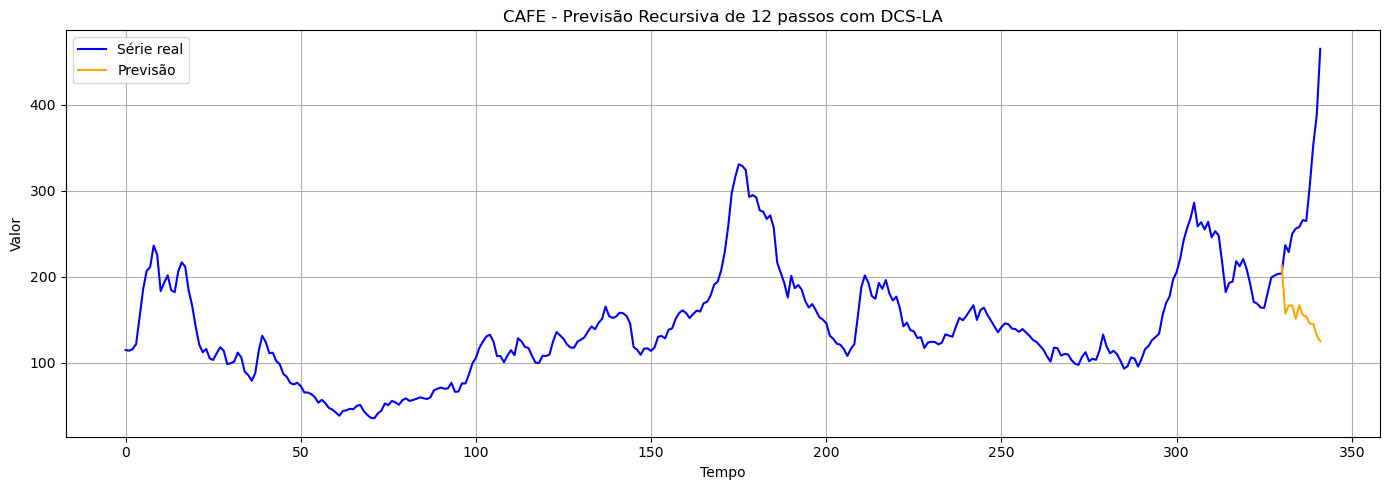


==> Série: MILHO
Valores reais:     [12.6, 11.64, 11.47, 10.73, 10.32, 10.73, 11.3, 12.22, 12.7, 11.96, 12.34, 13.54]
Valores previstos: [11.67, 10.01, 9.93, 9.24, 9.68, 10.35, 10.15, 11.03, 12.92, 13.76, 14.4, 14.64]
MSE da previsão recursiva (12 passos): 1.6802


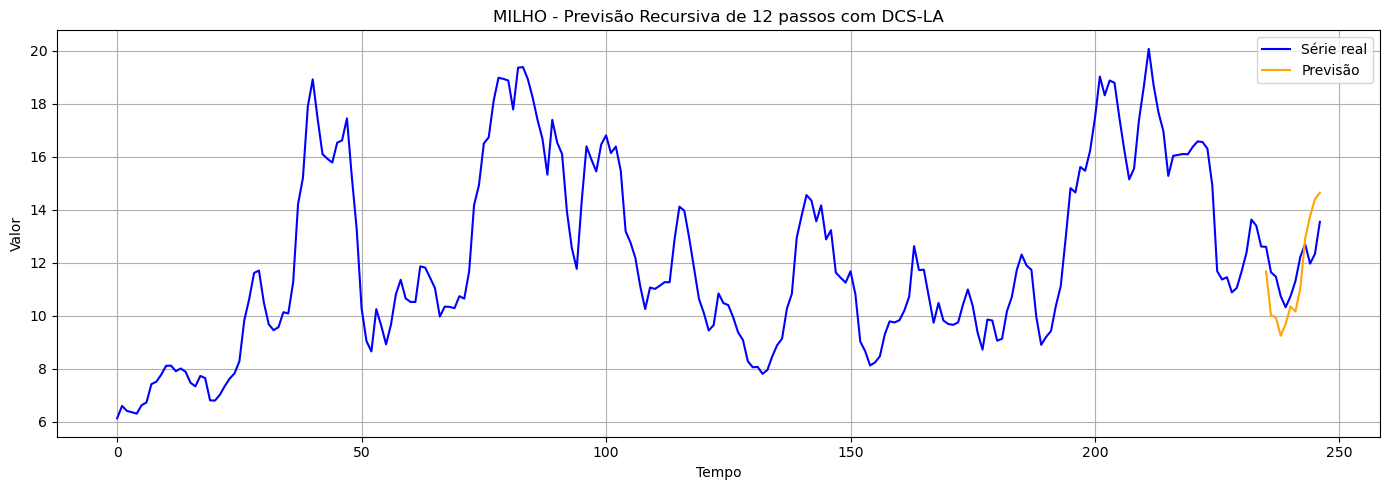


==> Série: SOJA
Valores reais:     [24.49, 24.74, 26.47, 25.76, 24.9, 23.99, 25.26, 25.22, 24.71, 23.17, 22.38, 22.77]
Valores previstos: [26.09, 27.61, 29.75, 30.38, 29.74, 30.56, 30.39, 30.9, 29.91, 28.92, 29.13, 29.3]
MSE da previsão recursiva (12 passos): 26.3889


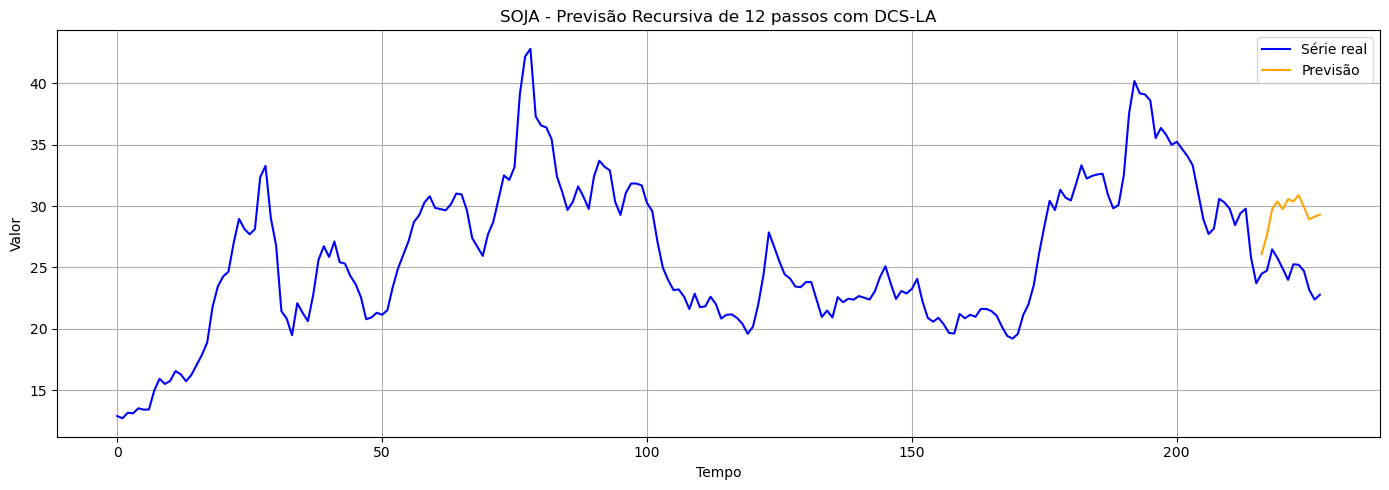

In [ ]:
for id in df_usd['unique_id'].unique():
    print(f'\n==> Série: {id}')

    y_series = series_data_usd[id]['y_series']
    y_real_future = y_series[-horizon_size:]
    y_train = y_series[:-horizon_size]

    curr_lags = y_train[-window_size:]
    forecast = []

    for step in range(horizon_size):
        windows, targets = extract_lag_windows(y_train, window_size=window_size)

        sims = cosine_similarity([curr_lags], windows)[0]
        top_k_idx = sims.argsort()[-10:]

        competence_X = windows[top_k_idx]
        competence_y = targets[top_k_idx]

        errors = evaluate_models(models, competence_X, competence_y)
        best_model = models[np.argmin(errors)]

        y_next = best_model.predict([curr_lags])[0]
        forecast.append(y_next)

        curr_lags = np.append(curr_lags[1:], y_next)
        y_train = np.append(y_train, y_next)

    print("Valores reais:    ", y_real_future.round(2).tolist())
    print("Valores previstos:", np.round(forecast, 2).tolist())
    mse = mean_squared_error(y_real_future, forecast)
    print(f"MSE da previsão recursiva ({horizon_size} passos): {mse:.4f}")

    plot_forecast(y_series, forecast, horizon_size, id)

### Similaridade por Distância Euclidiana


==> Série: ACUCAR
Valores reais:     [28.84, 28.72, 27.06, 25.17, 24.0, 23.55, 25.48, 27.15, 28.68, 26.51, 25.82, 25.23]
Valores previstos: [30.31, 30.3, 30.01, 30.66, 29.92, 30.17, 30.25, 30.23, 30.2, 30.27, 30.17, 30.23]
MSE da previsão recursiva (12 passos): 17.9106


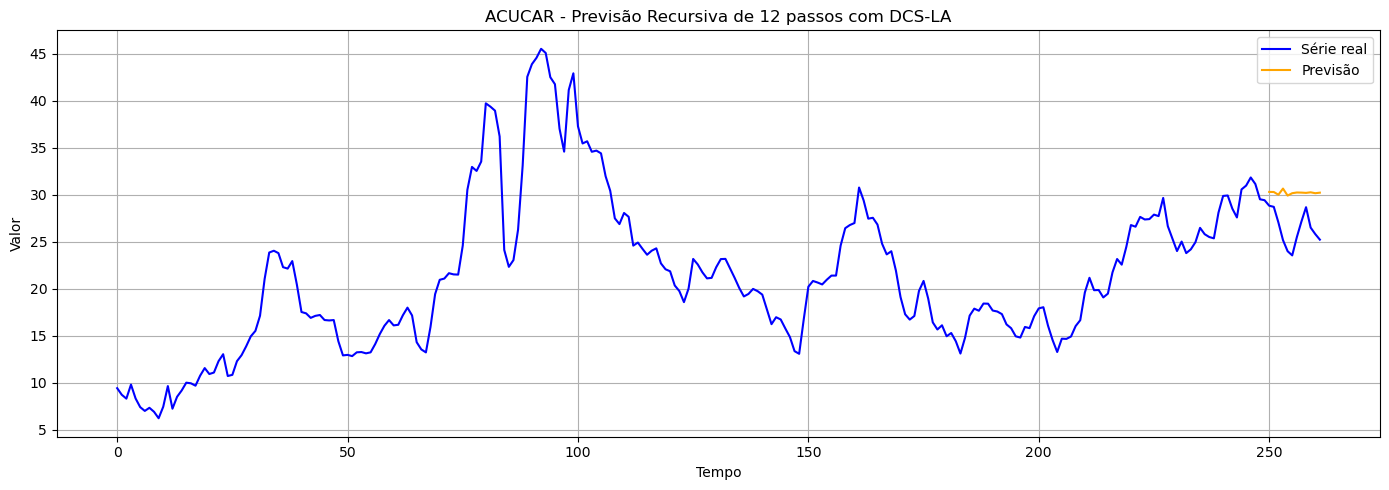


==> Série: ALGODAO
Valores reais:     [84.43, 77.64, 74.9, 72.75, 73.4, 71.95, 71.49, 70.42, 68.08, 67.89, 68.92, 71.48]
Valores previstos: [81.09, 81.62, 80.76, 81.01, 80.46, 81.16, 81.29, 81.51, 81.37, 81.23, 81.2, 81.3]
MSE da previsão recursiva (12 passos): 90.4186


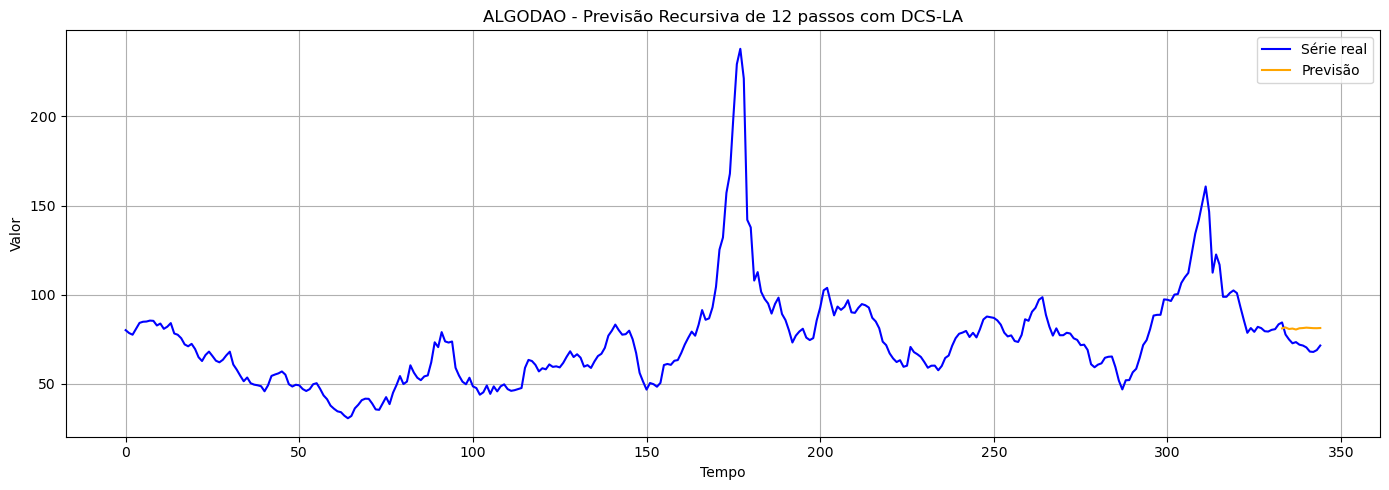


==> Série: CAFE
Valores reais:     [203.66, 236.77, 228.75, 250.16, 256.06, 257.86, 265.93, 264.88, 305.73, 353.49, 388.16, 465.36]
Valores previstos: [224.57, 242.82, 261.7, 284.38, 289.93, 283.04, 270.93, 256.01, 251.73, 248.82, 235.52, 223.6]
MSE da previsão recursiva (12 passos): 8353.0135


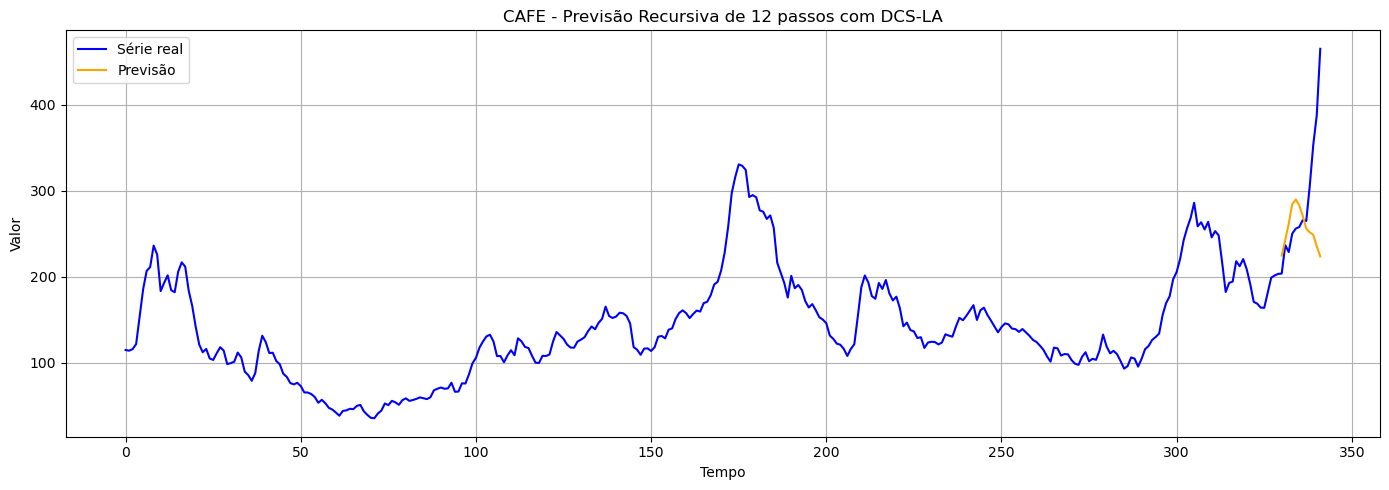


==> Série: MILHO
Valores reais:     [12.6, 11.64, 11.47, 10.73, 10.32, 10.73, 11.3, 12.22, 12.7, 11.96, 12.34, 13.54]
Valores previstos: [12.44, 11.69, 10.94, 10.75, 10.52, 10.34, 10.53, 10.63, 10.91, 11.71, 12.81, 13.69]
MSE da previsão recursiva (12 passos): 0.5975


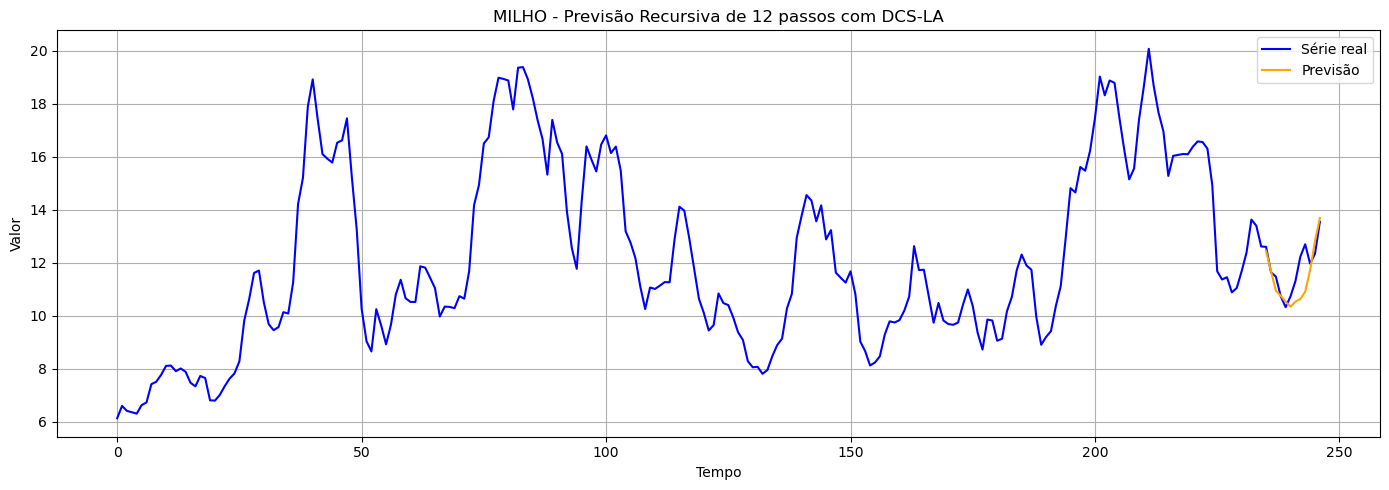


==> Série: SOJA
Valores reais:     [24.49, 24.74, 26.47, 25.76, 24.9, 23.99, 25.26, 25.22, 24.71, 23.17, 22.38, 22.77]
Valores previstos: [25.69, 25.25, 24.08, 22.51, 22.18, 22.47, 22.48, 22.91, 22.62, 22.69, 22.92, 23.43]
MSE da previsão recursiva (12 passos): 3.8355


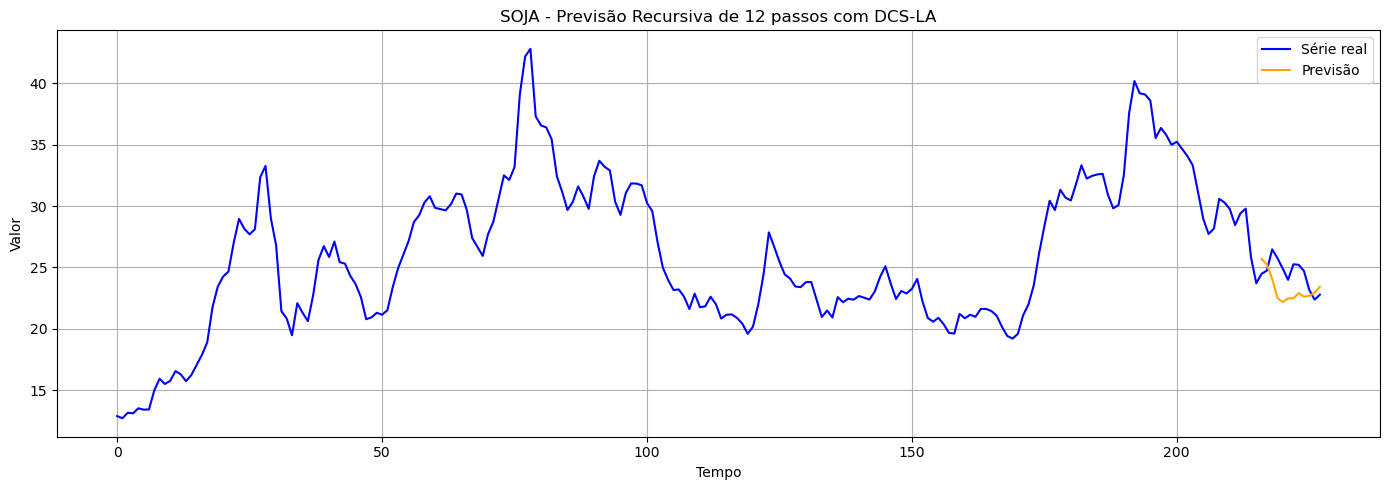

In [ ]:
for id in df_usd['unique_id'].unique():
    print(f'\n==> Série: {id}')

    y_series = series_data_usd[id]['y_series']
    y_real_future = y_series[-horizon_size:]
    y_train = y_series[:-horizon_size]

    curr_lags = y_train[-window_size:]
    forecast = []

    for step in range(horizon_size):
        windows, targets = extract_lag_windows(y_train, window_size=window_size)

        dists = euclidean_distances([curr_lags], windows)[0]
        top_k_idx = dists.argsort()[:10]

        competence_X = windows[top_k_idx]
        competence_y = targets[top_k_idx]

        errors = evaluate_models(models, competence_X, competence_y)
        best_model = models[np.argmin(errors)]

        y_next = best_model.predict([curr_lags])[0]
        forecast.append(y_next)

        curr_lags = np.append(curr_lags[1:], y_next)
        y_train = np.append(y_train, y_next)

    print("Valores reais:    ", y_real_future.round(2).tolist())
    print("Valores previstos:", np.round(forecast, 2).tolist())
    mse = mean_squared_error(y_real_future, forecast)
    print(f"MSE da previsão recursiva ({horizon_size} passos): {mse:.4f}")

    plot_forecast(y_series, forecast, horizon_size, id)